In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [2]:
df = pd.read_csv('car.data', 
                 names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'], 
                 header=None, index_col=False)

In [3]:
df

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [342]:
df.shape
# 1728 rows of data

(1728, 7)

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [309]:
# check distribution of buying price
df['buying'].value_counts()

med      432
low      432
vhigh    432
high     432
Name: buying, dtype: int64

## EDA

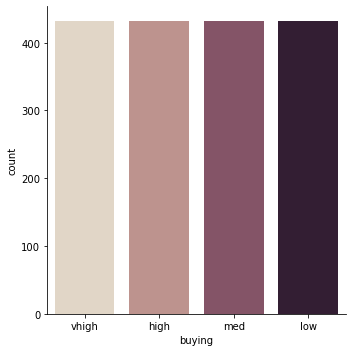

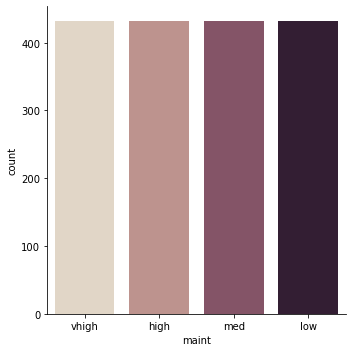

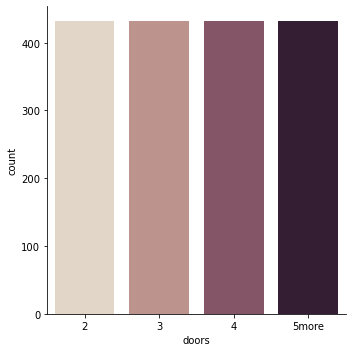

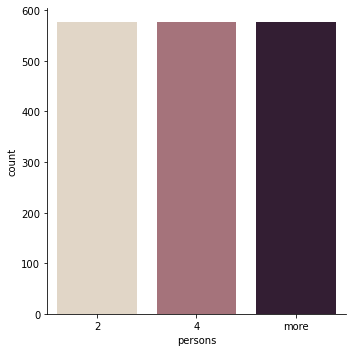

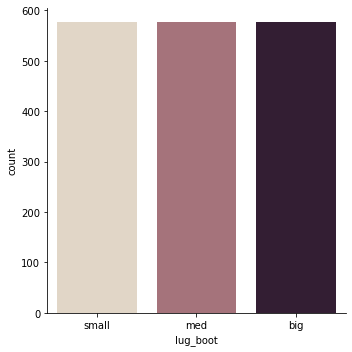

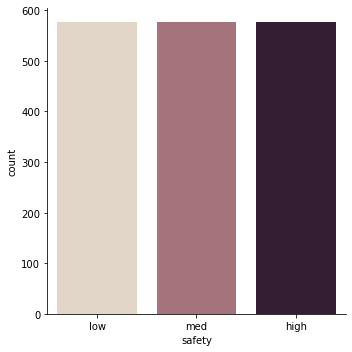

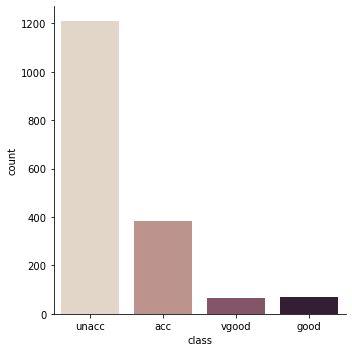

In [7]:
for col in df.columns:
    sns.catplot(x=col, kind="count", palette="ch:.25", data=df)

## Encode Label

In [311]:
encode = {
    "buying": {"low": 1, "med": 2, "high": 3, "vhigh": 4},
    "maint": {"low": 1, "med": 2, "high": 3, "vhigh": 4},
    "doors": {"2": 1, "3": 2, "4": 3, "5more": 4},
    "persons": {"2": 1, "4": 2, "more": 3},
    "lug_boot": {'small': 1, 'med': 2, 'big': 3},
    "safety": {'low': 1, 'med': 2, 'high': 3},
    "class": {'unacc': 1, 'acc': 2, 'good': 3, 'vgood': 4}
}

In [312]:
cleaned_df = df.replace(encode)

In [313]:
cleaned_df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,4,4,1,1,1,1,1
1,4,4,1,1,1,2,1
2,4,4,1,1,1,3,1
3,4,4,1,1,2,1,1
4,4,4,1,1,2,2,1


## Correlation

- Based on the heatmap below, there are no highly correlated variables.

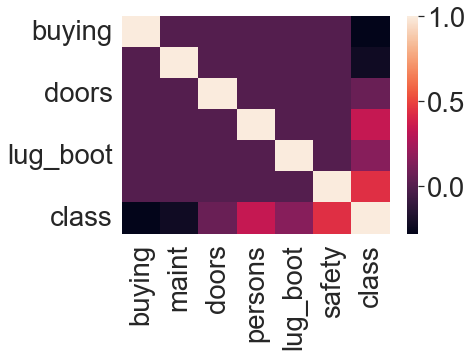

In [331]:
sns.heatmap(cleaned_df.corr())

## Split Data

In [314]:
from sklearn.model_selection import train_test_split

In [315]:
X = cleaned_df[['class', "maint", "doors", "persons", "lug_boot", "safety"]]
y = cleaned_df['buying']

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [319]:
X_train.shape, y_train.shape

((1209, 6), (1209,))

In [320]:
X_test.shape, y_test.shape

((519, 6), (519,))

## Experiment Multiple Models

In [322]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    dfs = []
    models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('CLF', DecisionTreeClassifier()),
        ('SVM', SVC()), 
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier())
    ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
        
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred))
    
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    
    return final

In [323]:
final = run_exps(X_train, y_train, X_test, y_test)
display(final)

LogReg
              precision    recall  f1-score   support

           1       0.37      0.36      0.37       135
           2       0.25      0.25      0.25       124
           3       0.35      0.18      0.24       133
           4       0.31      0.47      0.37       127

    accuracy                           0.32       519
   macro avg       0.32      0.32      0.31       519
weighted avg       0.32      0.32      0.31       519

RF
              precision    recall  f1-score   support

           1       0.15      0.16      0.15       135
           2       0.04      0.05      0.04       124
           3       0.02      0.02      0.02       133
           4       0.09      0.08      0.08       127

    accuracy                           0.08       519
   macro avg       0.08      0.08      0.08       519
weighted avg       0.08      0.08      0.08       519

KNN
              precision    recall  f1-score   support

           1       0.21      0.24      0.22       135
       

C:\Users\wangting\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:50:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,model
0,0.028019,0.003000,0.338843,0.322416,0.338843,0.322361,LogReg
1,0.025971,0.003001,0.355372,0.357061,0.355372,0.346118,LogReg
2,0.027027,0.002980,0.285124,0.279455,0.285124,0.271347,LogReg
3,0.029020,0.002990,0.280992,0.289127,0.280992,0.281026,LogReg
4,0.032010,0.002980,0.307054,0.302178,0.307054,0.297810,LogReg
5,0.165394,0.011997,0.107438,0.097436,0.107438,0.101028,RF
6,0.158022,0.012988,0.103306,0.111486,0.103306,0.106366,RF
7,0.146992,0.013989,0.099174,0.099646,0.099174,0.098564,RF
8,0.154020,0.012000,0.161157,0.163242,0.161157,0.161881,RF
9,0.143971,0.013003,0.170124,0.170476,0.170124,0.169668,RF


## Evaluate Results on 50 Samples

In [324]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=50, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

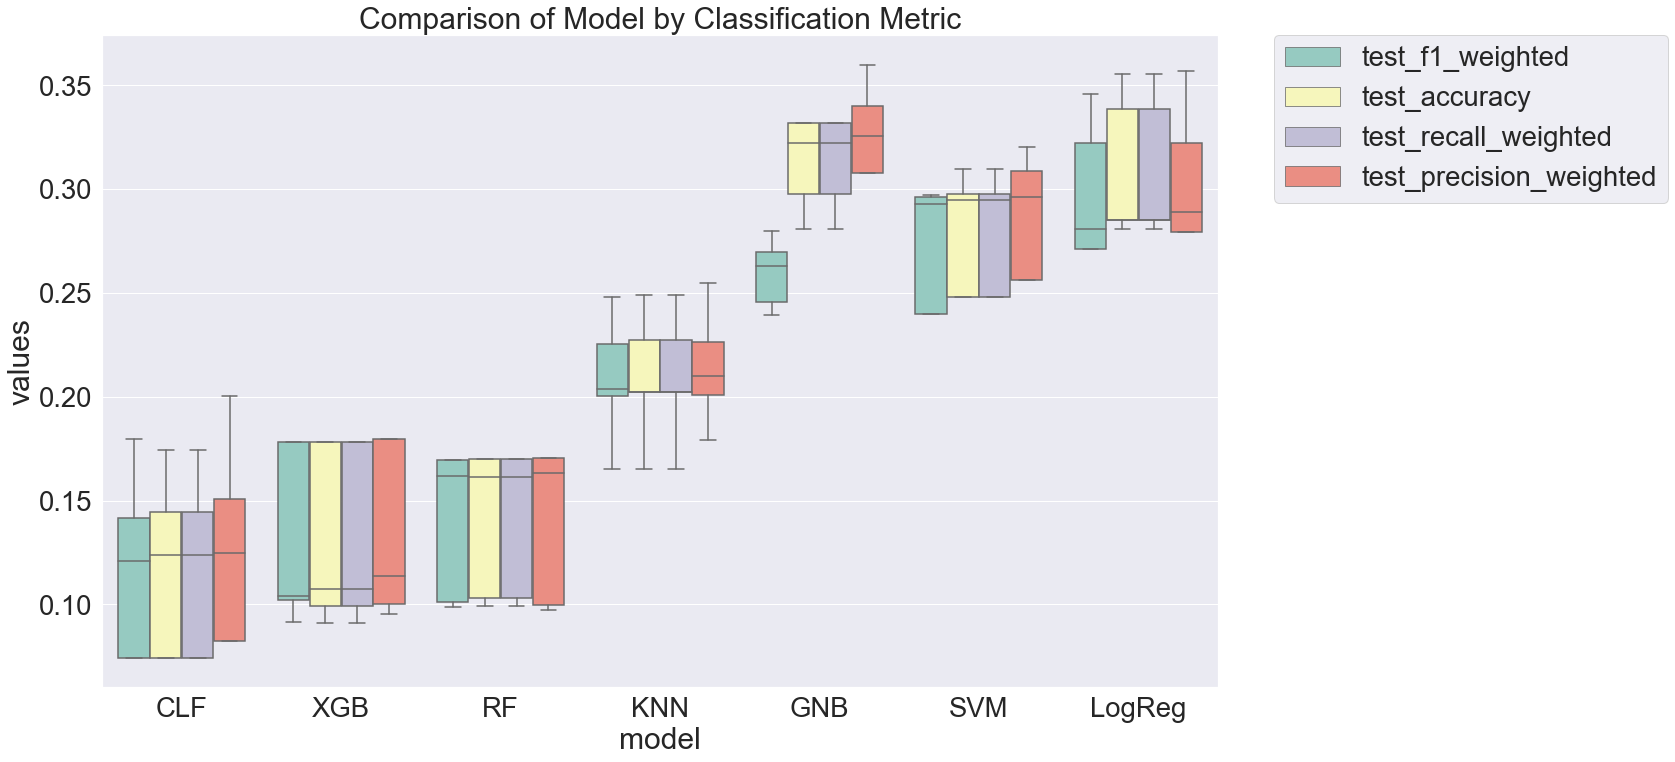

In [325]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

## Perform Gridsearch on Logistic Regression

*As Logistic Regression seemed to perform the best, I will tune the hyperparameters of Logistic Regression using GridSearchCV to identify if the model performance improves.*

In [332]:
lgr = LogisticRegression()

In [333]:
param_grid = ({
    "penalty": ['l1','l2','elasticnet','none'],
    "C": [0.01, 0.1, 1],
    "solver": ['newton-cg','lbfgs','liblinear','sag','saga']
})

In [334]:
grid = GridSearchCV(lgr, param_grid, refit = True, verbose = 3, n_jobs=-1, cv=10) 

In [335]:
grid.fit(X_train, y_train) 

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    7.1s finished
C:\Users\wangting\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=3)

In [336]:
print(grid.best_params_)

{'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}


In [338]:
grid_predictions = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))

Accuracy: 0.3159922928709056
              precision    recall  f1-score   support

           1       0.37      0.36      0.37       135
           2       0.25      0.25      0.25       124
           3       0.35      0.18      0.24       133
           4       0.31      0.47      0.37       127

    accuracy                           0.32       519
   macro avg       0.32      0.32      0.31       519
weighted avg       0.32      0.32      0.31       519



*The results are somewhat similar (there may be some discrepancies in the decimals when the metrics values are rounded up, but essentially, Logistic Regression performs better than the other models and is the chosen model.* 